### Importación de librerias


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import glob
from scipy.signal import butter, filtfilt, welch, detrend
from statsmodels.nonparametric.smoothers_lowess import lowess
from skimage.restoration import denoise_nl_means, estimate_sigma

### Funciones de filtrado

In [2]:
def filtro_wavelet(signal, wavelet='db4', nivel=6):
    # Nivel bajo para evitar reducción excesiva de tamaño
    max_nivel = min(nivel, pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len))
    coeffs = pywt.wavedec(signal, wavelet, level=max_nivel)
    coeffs[0] = np.zeros_like(coeffs[0])
    sigma_est = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma_est * np.sqrt(2 * np.log(len(signal)))
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold, mode='soft')
    rec = pywt.waverec(coeffs, wavelet)
    # Asegura que la señal tenga el mismo tamaño
    if len(rec) > len(signal):
        rec = rec[:len(signal)]
    return rec

def filtro_pasabajas(signal, fs=500, cutoff=50, order=4):
    b, a = butter(order, cutoff / (0.5 * fs), btype='low')
    return filtfilt(b, a, signal)

def filtro_pasaaltas(signal, fs=500, cutoff=0.5, order=4):
    b, a = butter(order, cutoff / (0.5 * fs), btype='high')
    return filtfilt(b, a, signal)

def filtro_loess(signal, frac=0.01):
    if len(signal) < 2:
        return signal
    result = lowess(signal, np.arange(len(signal)), frac=frac, return_sorted=False)
    if np.any(np.isnan(result)):
        result = np.where(np.isnan(result), signal, result)
    return result

def filtro_nlm_1d(signal, k=7):
    if np.any(np.isnan(signal)):
        signal = np.nan_to_num(signal)
    return np.convolve(signal, np.ones(k)/k, mode='same')



### Funciones de flujo de procesamiento


In [3]:
def flujo1(signal, fs=500):
    return filtro_pasabajas(filtro_wavelet(filtro_pasaaltas(signal, fs), 'db4'), fs)

def flujo2(signal, fs=500):
    return filtro_pasabajas(filtro_wavelet(detrend(signal), 'db4'), fs)

def flujo3(signal, fs=500):
    s1 = filtro_pasabajas(signal, fs)
    s2 = filtro_loess(s1)
    return filtro_nlm_1d(s2)



### Cargar y seleccionar señales

In [ ]:
def cargar_derivacion_II(ruta_archivo):
    data = np.genfromtxt(ruta_archivo, delimiter=',', skip_header=1)
    return data[:, 1]  # derivación II

# Ruta correcta a tu carpeta ECG
ruta_carpeta = 'ECGData/*.csv'

# Cargar los archivos
lista_archivos = glob.glob(ruta_carpeta)
print(f"Se encontraron {len(lista_archivos)} archivos.")

# Selección aleatoria
np.random.seed(42)
archivos_10 = np.random.choice(lista_archivos, size=10, replace=False)



Se encontraron 10646 archivos.


### Procesamiento por flujo y cálculo de fMP

MUSE_20180111_165814_46000.csv - len(f3): 5000, NaNs: 0, min: -190.598048339436, max: 215.24293421264318


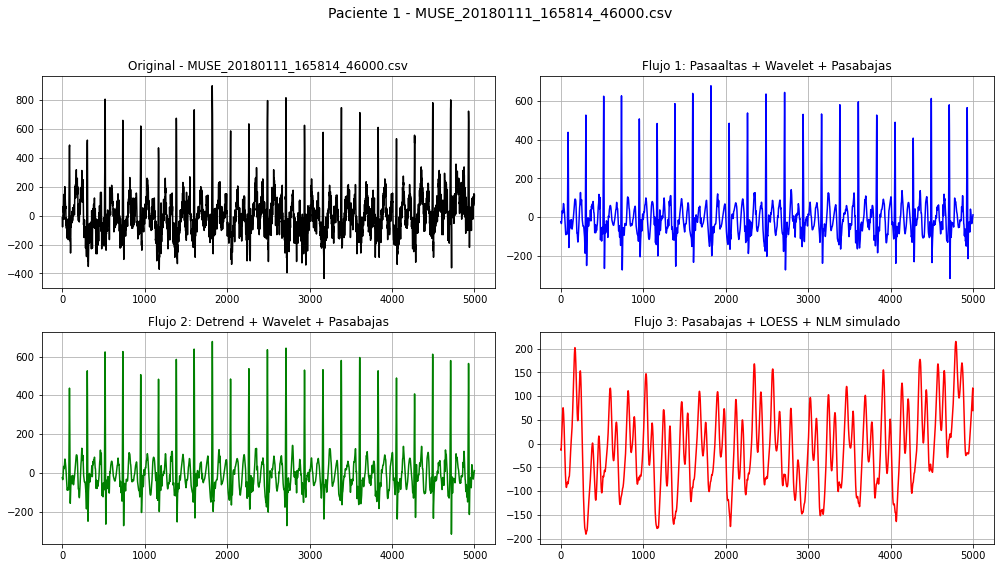

MUSE_20180114_121142_54000.csv - len(f3): 5000, NaNs: 0, min: -96.03455329435297, max: 392.8522533012676


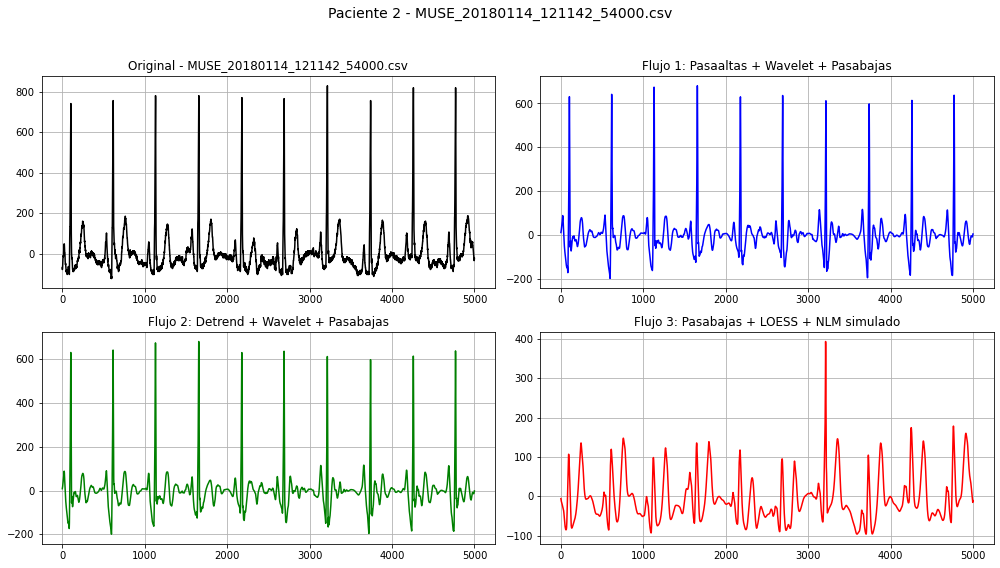

MUSE_20180712_151451_06000.csv - len(f3): 5000, NaNs: 0, min: -225.1090598813002, max: 209.12255292463993


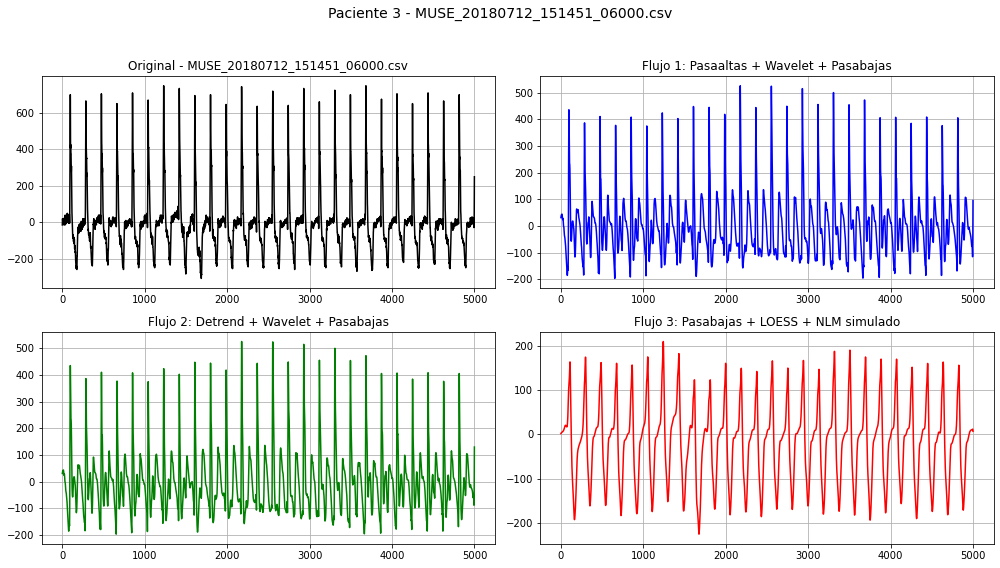

MUSE_20180114_072329_74000.csv - len(f3): 5000, NaNs: 0, min: -181.93810681737227, max: 274.97306365911265


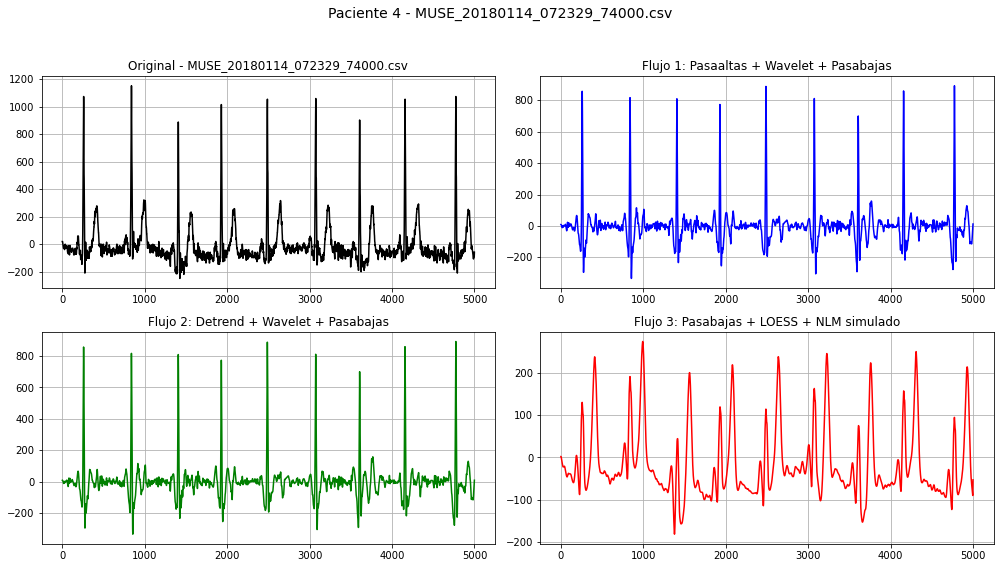

MUSE_20180209_171534_23000.csv - len(f3): 5000, NaNs: 0, min: -138.6954020665279, max: 223.69825956120587


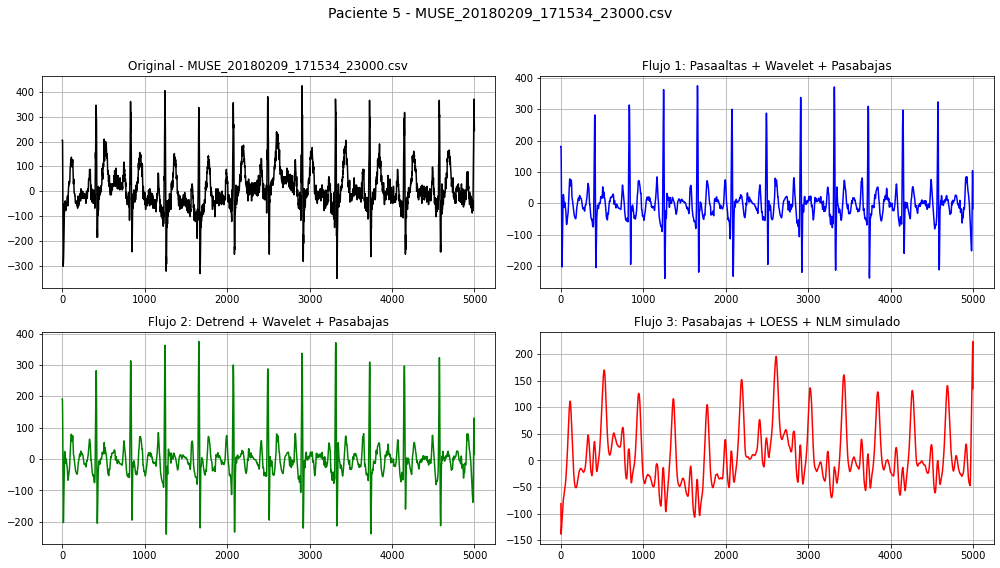

MUSE_20180111_165639_72000.csv - len(f3): 5000, NaNs: 0, min: -151.0354507986211, max: 177.1205797846814


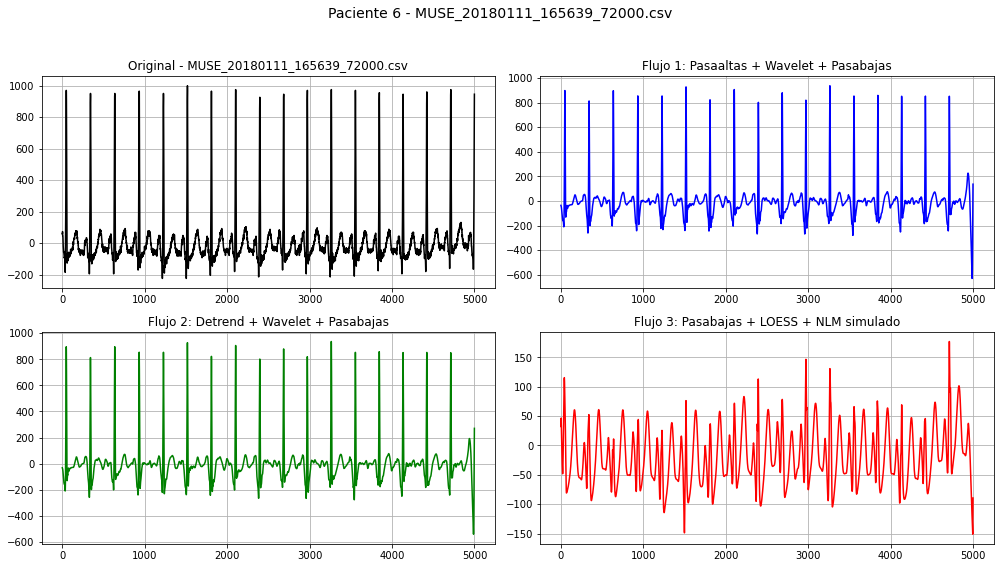

MUSE_20180210_115759_28000.csv - len(f3): 5000, NaNs: 0, min: -141.44836364823686, max: 343.90953540638037


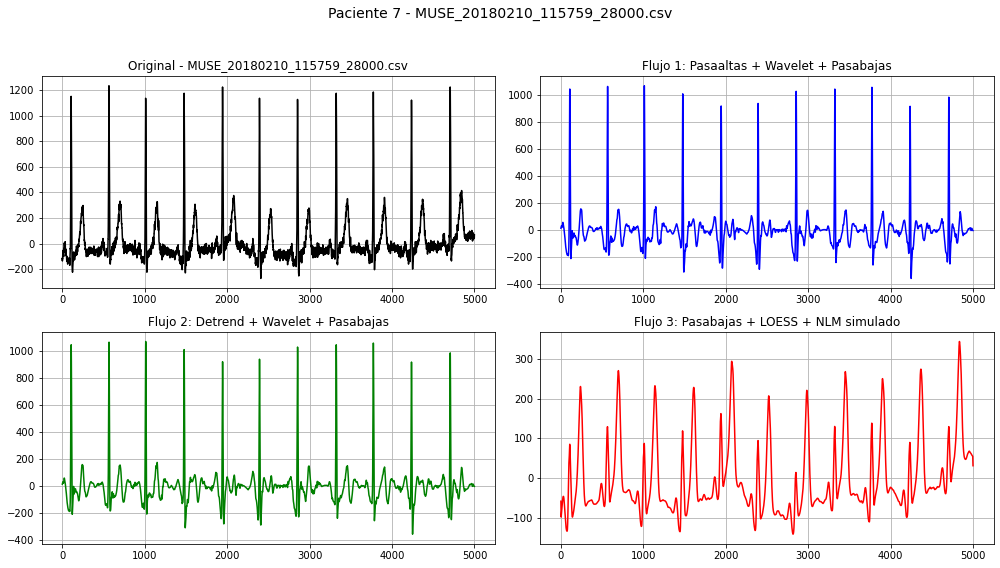

MUSE_20180114_074926_01000.csv - len(f3): 5000, NaNs: 0, min: -451.16555294231955, max: 928.7415519003348


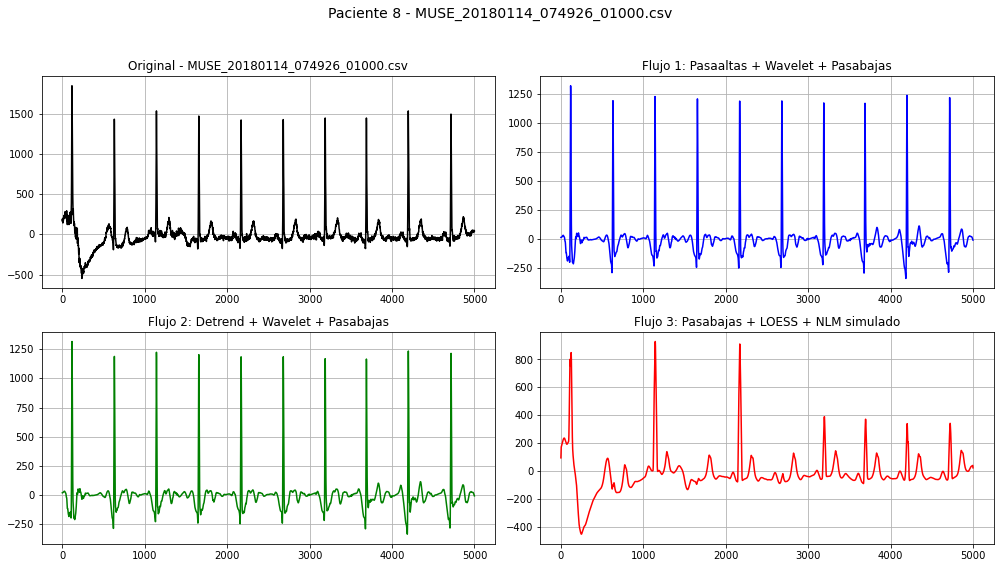

MUSE_20180113_130048_24000.csv - len(f3): 5000, NaNs: 0, min: -147.2687258821089, max: 149.01663212561482


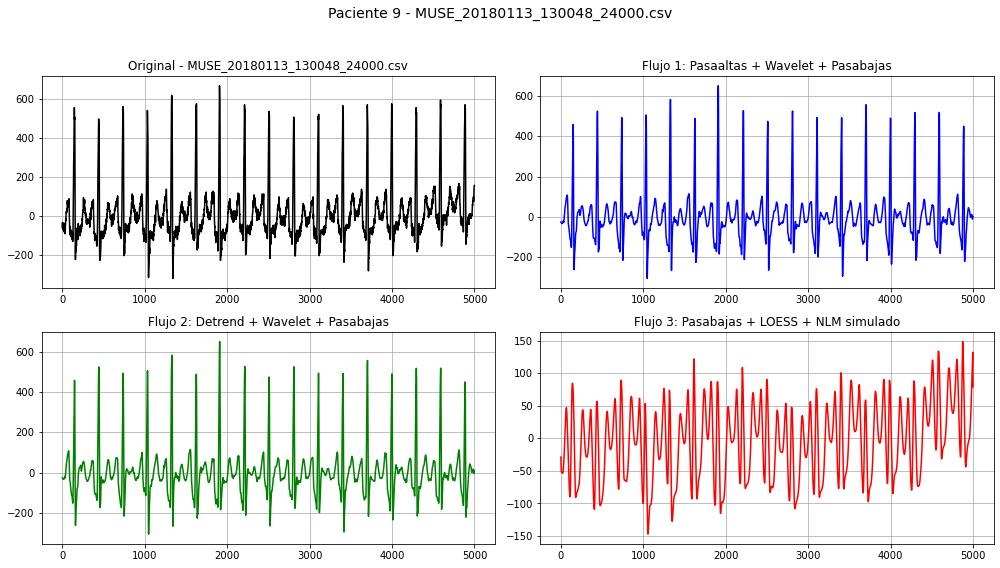

MUSE_20180120_122216_77000.csv - len(f3): 5000, NaNs: 0, min: -142.40869906787248, max: 386.44882017673496


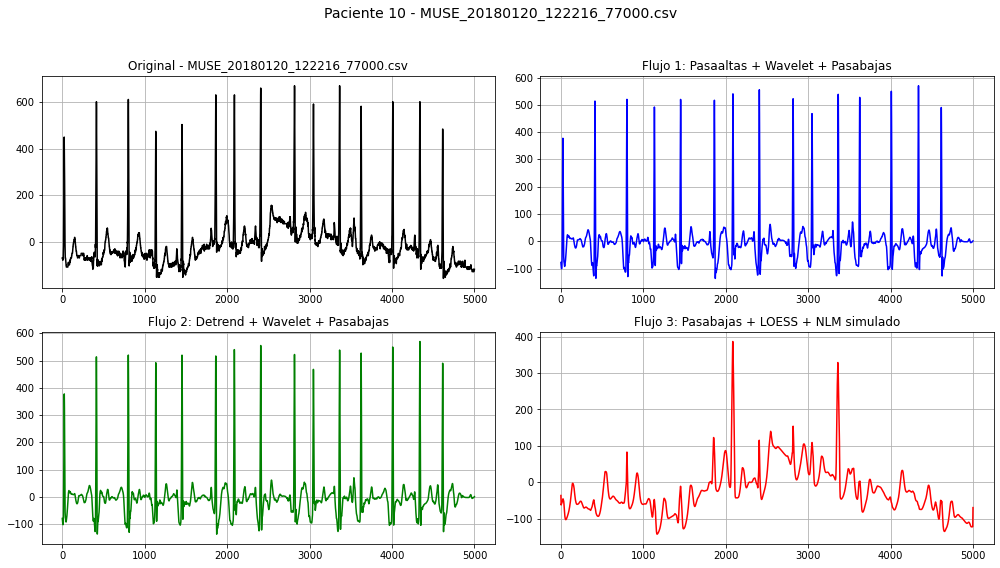

In [39]:
def calcular_fMP(signal, fs=500):
    # Robustez: chequea que la señal sea válida
    if signal is None or len(signal) == 0 or np.all(np.isnan(signal)):
        return np.nan
    f, Pxx = welch(signal, fs)
    if len(Pxx) == 0:
        return np.nan
    return f[np.argmax(Pxx)]

resultados = []

for i, archivo in enumerate(archivos_10):
    nombre = archivo.split('/')[-1] if '/' in archivo else archivo.split('\\')[-1]
    estado = nombre.split('_')[0]
    ecg = cargar_derivacion_II(archivo)

    # Aplicar flujos (¡robustos!)
    f1 = flujo1(ecg)
    f2 = flujo2(ecg)
    f3 = flujo3(ecg)
    
    # Diagnóstico para f3 (puedes comentar después de probar)
    print(f"{nombre} - len(f3): {len(f3)}, NaNs: {np.isnan(f3).sum()}, min: {np.nanmin(f3)}, max: {np.nanmax(f3)}")
    
    # Calcular fMP
    fmp1 = calcular_fMP(f1)
    fmp2 = calcular_fMP(f2)
    fmp3 = calcular_fMP(f3)
    resultados.append((nombre, estado, fmp1, fmp2, fmp3))
    
    # Graficar
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 2, 1)
    plt.plot(ecg, color='black')
    plt.title(f"Original - {nombre}")
    plt.grid(True)
    plt.subplot(2, 2, 2)
    plt.plot(f1, color='blue')
    plt.title("Flujo 1: Pasaaltas + Wavelet + Pasabajas")
    plt.grid(True)
    plt.subplot(2, 2, 3)
    plt.plot(f2, color='green')
    plt.title("Flujo 2: Detrend + Wavelet + Pasabajas")
    plt.grid(True)
    plt.subplot(2, 2, 4)
    plt.plot(f3, color='red')
    plt.title("Flujo 3: Pasabajas + LOESS + NLM simulado")
    plt.grid(True)
    plt.suptitle(f"Paciente {i+1} - {nombre}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [40]:
df_resultados = pd.DataFrame(resultados, columns=["Registro", "Estado", "fMP_Flujo1", "fMP_Flujo2", "fMP_Flujo3"])
display(df_resultados)

df_resultados.to_csv("resultados_flujos.csv", index=False)
print("✔ Resultados guardados como 'resultados_flujos.csv'")

,Registro,Estado,fMP_Flujo1,fMP_Flujo2,fMP_Flujo3
0,MUSE_20180111_165814_46000.csv,MUSE,7.812500,7.812500,1.953125
1,MUSE_20180114_121142_54000.csv,MUSE,5.859375,5.859375,3.906250
2,MUSE_20180712_151451_06000.csv,MUSE,5.859375,5.859375,1.953125
3,MUSE_20180114_072329_74000.csv,MUSE,7.812500,7.812500,1.953125
4,MUSE_20180209_171534_23000.csv,MUSE,7.812500,7.812500,1.953125
5,MUSE_20180111_165639_72000.csv,MUSE,9.765625,9.765625,3.906250
6,MUSE_20180210_115759_28000.csv,MUSE,7.812500,7.812500,1.953125
7,MUSE_20180114_074926_01000.csv,MUSE,5.859375,5.859375,3.906250
8,MUSE_20180113_130048_24000.csv,MUSE,5.859375,5.859375,5.859375
9,MUSE_20180120_122216_77000.csv,MUSE,7.812500,7.812500,3.906250


✔ Resultados guardados como 'resultados_flujos.csv'


Media y desviación estándar de fMP por flujo:
fMP_Flujo1: media=7.23, std=1.32, min=5.86, max=9.77
fMP_Flujo2: media=7.23, std=1.32, min=5.86, max=9.77
fMP_Flujo3: media=3.12, std=1.37, min=1.95, max=5.86

Valores atípicos (fuera de 1.5 * IQR):
fMP_Flujo1: 0 valores atípicos.
fMP_Flujo2: 0 valores atípicos.
fMP_Flujo3: 0 valores atípicos.


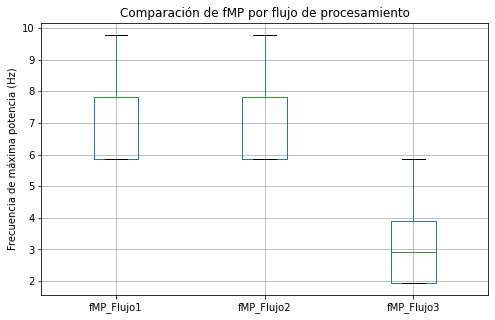

In [41]:

# Estadística descriptiva
print("Media y desviación estándar de fMP por flujo:")
for col in ["fMP_Flujo1", "fMP_Flujo2", "fMP_Flujo3"]:
    media = df_resultados[col].mean()
    std = df_resultados[col].std()
    min_ = df_resultados[col].min()
    max_ = df_resultados[col].max()
    print(f"{col}: media={media:.2f}, std={std:.2f}, min={min_:.2f}, max={max_:.2f}")

# Detección de valores atípicos (outliers simples)
print("\nValores atípicos (fuera de 1.5 * IQR):")
for col in ["fMP_Flujo1", "fMP_Flujo2", "fMP_Flujo3"]:
    Q1 = df_resultados[col].quantile(0.25)
    Q3 = df_resultados[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_resultados[(df_resultados[col] < Q1 - 1.5*IQR) | (df_resultados[col] > Q3 + 1.5*IQR)][col]
    print(f"{col}: {len(outliers)} valores atípicos.")

# Boxplot para comparar flujos
plt.figure(figsize=(8,5))
df_resultados[["fMP_Flujo1", "fMP_Flujo2", "fMP_Flujo3"]].boxplot()
plt.ylabel("Frecuencia de máxima potencia (Hz)")
plt.title("Comparación de fMP por flujo de procesamiento")
plt.grid(True)
plt.show()


Con base en la comparación visual del boxplot, el Flujo 1 es el más adecuado para el procesamiento de las señales ECG. Presenta valores de frecuencia de máxima potencia (fMP) dentro de un rango fisiológico esperado, similar al Flujo 2 pero con menor dispersión. Por el contrario, el Flujo 3 tiende a producir valores considerablemente menores, lo que sugiere un exceso de suavizado y posible pérdida de información relevante de la señal. Por ello, para el resto del trabajo se selecciona el Flujo 1, que garantiza una mejor preservación de las características espectrales y morfológicas del ECG.

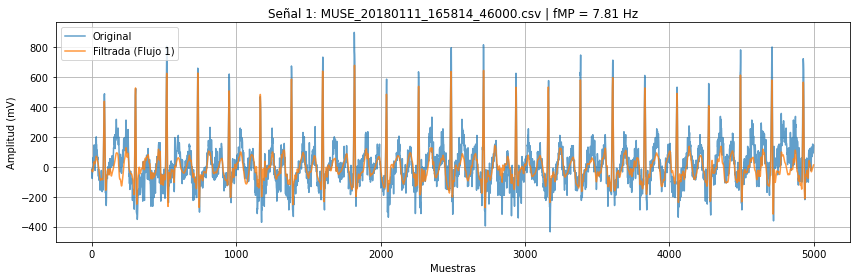

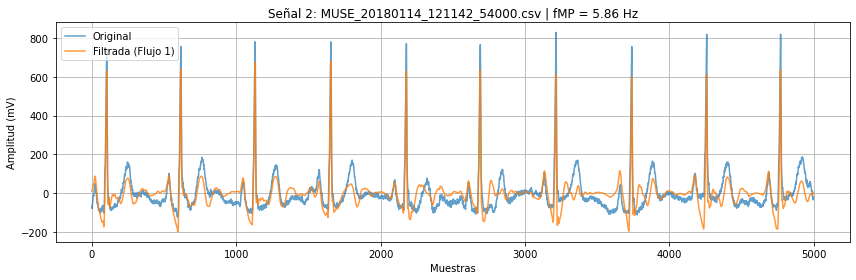

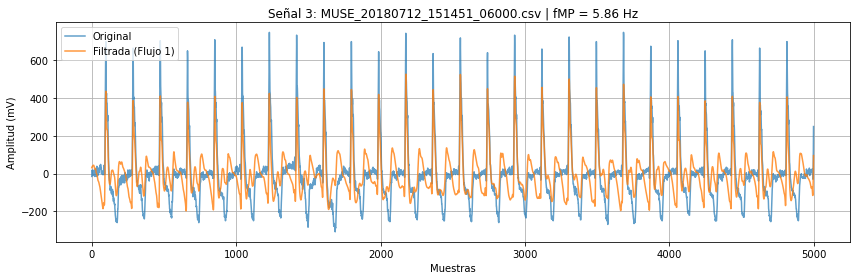

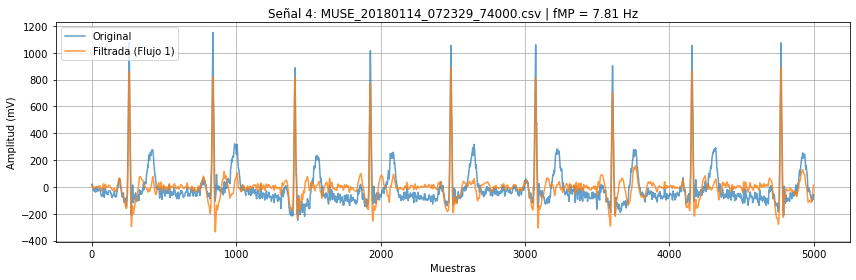

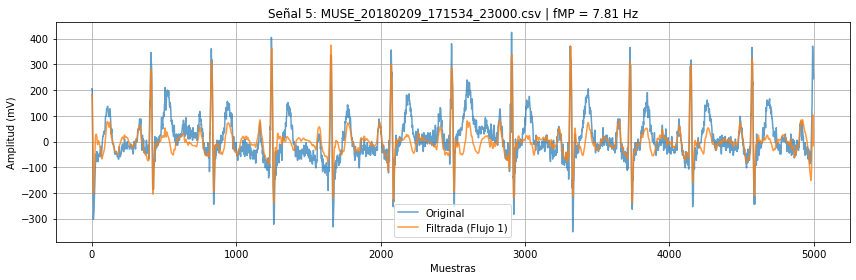

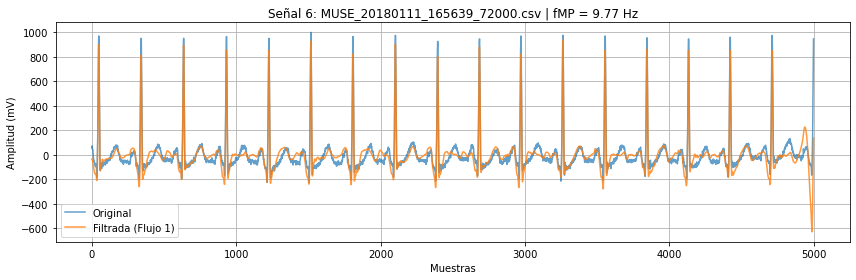

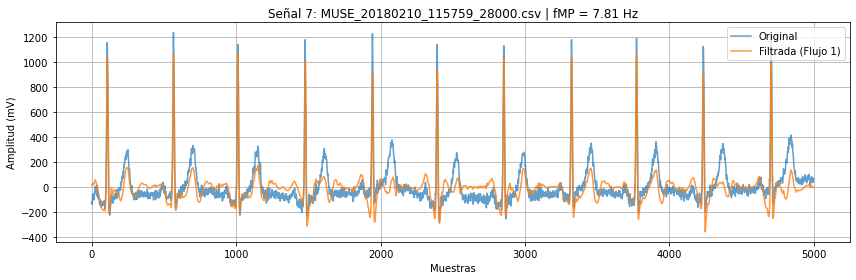

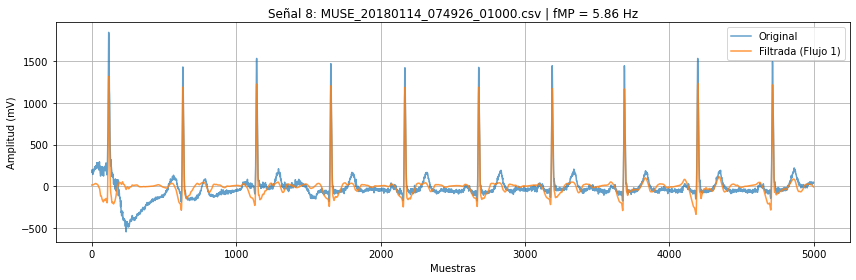

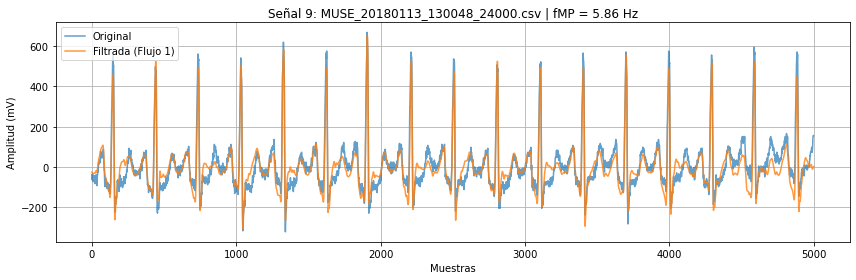

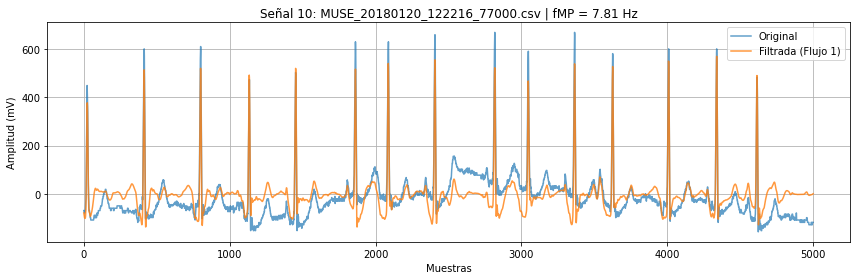

,Registro,Estado,fMP
0,MUSE_20180111_165814_46000.csv,MUSE,7.812500
1,MUSE_20180114_121142_54000.csv,MUSE,5.859375
2,MUSE_20180712_151451_06000.csv,MUSE,5.859375
3,MUSE_20180114_072329_74000.csv,MUSE,7.812500
4,MUSE_20180209_171534_23000.csv,MUSE,7.812500
5,MUSE_20180111_165639_72000.csv,MUSE,9.765625
6,MUSE_20180210_115759_28000.csv,MUSE,7.812500
7,MUSE_20180114_074926_01000.csv,MUSE,5.859375
8,MUSE_20180113_130048_24000.csv,MUSE,5.859375
9,MUSE_20180120_122216_77000.csv,MUSE,7.812500


✔ Resultados guardados como 'resultados_flujo1.csv'


In [42]:
resultados_flujo1 = []

for i, archivo in enumerate(archivos_10):
    nombre = archivo.split('/')[-1] if '/' in archivo else archivo.split('\\')[-1]
    estado = nombre.split('_')[0]
    ecg = cargar_derivacion_II(archivo)
    
    # Procesar con Flujo 1
    ecg_filtrada = flujo1(ecg)
    
    # Calcular frecuencia de máxima potencia
    fmp = calcular_fMP(ecg_filtrada)
    resultados_flujo1.append((nombre, estado, fmp))
    
    # Graficar original y filtrada
    plt.figure(figsize=(12, 4))
    plt.plot(ecg, label="Original", alpha=0.7)
    plt.plot(ecg_filtrada, label="Filtrada (Flujo 1)", alpha=0.8)
    plt.title(f"Señal {i+1}: {nombre} | fMP = {fmp:.2f} Hz")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud (mV)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Guardar resultados
df_flujo1 = pd.DataFrame(resultados_flujo1, columns=["Registro", "Estado", "fMP"])
display(df_flujo1)

df_flujo1.to_csv("resultados_flujo1.csv", index=False)
print("✔ Resultados guardados como 'resultados_flujo1.csv'")


In [43]:
# Asumiendo que ya tienes tu DataFrame de diagnóstico:
df_diag = pd.read_excel("Diagnostics.xlsx")  # Ajusta el nombre si es distinto

# Procesar las 10 señales seleccionadas
resultados_flujo1 = []

for i, archivo in enumerate(archivos_10):
    nombre = archivo.split('/')[-1] if '/' in archivo else archivo.split('\\')[-1]
    estado = nombre.split('_')[0]
    ecg = cargar_derivacion_II(archivo)
    
    ecg_filtrada = flujo1(ecg)
    fmp = calcular_fMP(ecg_filtrada)
    resultados_flujo1.append((nombre, estado, fmp))

df_flujo1 = pd.DataFrame(resultados_flujo1, columns=["Registro", "Estado", "fMP"])

# Unir con la columna de diagnóstico
df_flujo1 = df_flujo1.merge(df_diag, on="Registro", how="left")
df_flujo1 = df_flujo1.rename(columns={"Diagnóstico": "Tipo de patología"})  # Cambia si tu Excel usa otro nombre

display(df_flujo1)
df_flujo1.to_csv("resultados_flujo1_10senales.csv", index=False)
print("✔ Resultados guardados como 'resultados_flujo1_10senales.csv'")

KeyError: 'Registro'

Punto 6: Creación de rutina y procesamiento de todas las señales

In [73]:
import os
from glob import glob
# Función única de procesamiento (flujo 1) y extracción de fMP
def procesar_senal(signal, fs=500, wavelet='db4', level=4):
    # 1. Pasaaltas IIR
    b1, a1 = butter(4, 0.5 / (fs / 2), btype='high')
    signal = filtfilt(b1, a1, signal)
    
    # 2. Wavelet modificado
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]  # suprimir detalles
    signal = pywt.waverec(coeffs, wavelet)
    
    # 3. Pasabajas IIR
    b2, a2 = butter(4, 50 / (fs / 2), btype='low')
    signal = filtfilt(b2, a2, signal)
    
    # 4. Welch para fMP
    f, Pxx = welch(signal, fs=fs, nperseg=1024)
    idx_max = np.argmax(Pxx)
    fmp = f[idx_max]
    
    return fmp

# Procesamiento de todos los archivos
#carpeta = "./ECGData"
ruta_carpeta = "ECGData"
archivos = glob(os.path.join(ruta_carpeta, "*.csv"))
print(f" Total archivos encontrados: {len(archivos)}")
fs = 500

resultados = []

for ruta in archivos:
    try:
        nombre_archivo = os.path.basename(ruta)
        registro = os.path.splitext(nombre_archivo)[0]
        señal = cargar_derivacion_II(ruta)

        fmp = procesar_senal(señal, fs)

        # Extraer Estado desde nombre si es posible
        estado = registro.split("_")[1] if "_" in registro else "Desconocido"
        resultados.append({"Registro": registro, "Estado": estado, "FMP": fmp})
    
    except Exception as e:
        print(f"Error procesando {ruta}: {e}")

# Crear y guardar DataFrame
df_fmp = pd.DataFrame(resultados)
df_fmp.to_excel("Resultados_FMP_Proyecto3.xlsx", index=False)
print("Exportación completada correctamente.")

 Total archivos encontrados: 10646
Exportación completada correctamente.


Verificamos el archivo que cabos de crear

In [ ]:
# Cargar el archivo Excel generado
df_fmp = pd.read_excel("Resultados_FMP_Proyecto3.xlsx")

# Limpiar posibles espacios en los nombres de columnas
df_fmp.columns = df_fmp.columns.str.strip()

# Mostrar las columnas encontradas
print(" Columnas del archivo:")
print(df_fmp.columns.tolist())

# Verificar columnas esperadas
esperadas = {"Registro", "Estado", "FMP"}
actuales = set(df_fmp.columns)

if esperadas.issubset(actuales):
    print(" La estructura del archivo es correcta.")
else:
    print("El archivo NO tiene la estructura esperada.")
    print("Faltan columnas:", esperadas - actuales)

# Mostrar total de registros
print(f" Total de registros procesados: {len(df_fmp)}")

# Mostrar un resumen general
print("\n Resumen estadístico de fMP:")
print(df_fmp["FMP"].describe())

# Verificar si hay valores faltantes
print("\n Valores faltantes por columna:")
print(df_fmp.isnull().sum())

# Mostrar los primeros 5 registros
print("\n Primeros 5 registros:")
print(df_fmp.head())

📄 Columnas del archivo:
['Registro', 'Estado', 'FMP']
 La estructura del archivo es correcta.
 Total de registros procesados: 10646

 Resumen estadístico de fMP:
count    10646.000000
mean         3.202356
std          2.185112
min          0.488281
25%          0.976562
50%          2.929688
75%          4.394531
max         13.671875
Name: FMP, dtype: float64

 Valores faltantes por columna:
Registro    0
Estado      0
FMP         0
dtype: int64

 Primeros 5 registros:
                     Registro    Estado       FMP
0  MUSE_20180111_155115_19000  20180111  1.953125
1  MUSE_20180111_155154_74000  20180111  4.882812
2  MUSE_20180111_155203_15000  20180111  3.906250
3  MUSE_20180111_155249_70000  20180111  1.953125
4  MUSE_20180111_155542_84000  20180111  3.417969


In [72]:
import pandas as pd

# 1. Cargar archivo de resultados fMP
df_fmp = pd.read_excel("Resultados_FMP_Proyecto3.xlsx")
df_fmp.columns = df_fmp.columns.str.strip()

# 2. Cargar archivo de diagnóstico desde Excel
df_diag = pd.read_excel("Diagnostics.xlsx")
df_diag.columns = df_diag.columns.str.strip()

# 3. Renombrar columnas para facilitar el merge (ajusta si tienen otros nombres)
df_diag = df_diag.rename(columns={"FileName": "Registro", "Rhythm": "Arritmia"})

# 4. Hacer el merge por la columna "Registro"
df_merged = df_fmp.merge(df_diag[["Registro", "Arritmia"]], on="Registro", how="left")

# 5. Reemplazar columna "Estado" por la nueva
df_merged = df_merged.drop(columns=["Estado"])
df_merged = df_merged.rename(columns={"Arritmia": "Estado"})

# 6. Guardar resultado final
df_merged.to_excel("Resultados_FMP_Proyecto3_con_arritmia.xlsx", index=False)
print(" Archivo final con diagnóstico de arritmia generado correctamente.")

# 7. Mostrar resumen de asignación
num_nan = df_merged["Estado"].isna().sum()
if num_nan > 0:
    print(f" {num_nan} registros no tienen diagnóstico asociado.")
else:
    print(" Todos los registros tienen su tipo de arritmia asignado.")

 Archivo final con diagnóstico de arritmia generado correctamente.
 Todos los registros tienen su tipo de arritmia asignado.


Verificamos la estructura del nuevo archivo

In [ ]:
# Cargar el archivo generado
df_final = pd.read_excel("Resultados_FMP_Proyecto3_con_arritmia.xlsx")
df_final.columns = df_final.columns.str.strip()  # limpiar nombres

# Mostrar nombres de columnas
print(" Columnas del archivo:")
print(df_final.columns.tolist())

# Total de registros
print(f"\n Total de registros: {len(df_final)}")

# Primeras 5 filas
print("\n Primeros 5 registros:")
print(df_final.head())

# Conteo por tipo de arritmia
print("\n Conteo por tipo de arritmia:")
print(df_final["Estado"].value_counts(dropna=False))

# Verificar valores faltantes
print("\n Valores faltantes por columna:")
print(df_final.isnull().sum())

 Columnas del archivo:
['Registro', 'FMP', 'Estado']

 Total de registros: 10646

 Primeros 5 registros:
                     Registro       FMP Estado
0  MUSE_20180111_155115_19000  1.953125     ST
1  MUSE_20180111_155154_74000  4.882812   AFIB
2  MUSE_20180111_155203_15000  3.906250   AFIB
3  MUSE_20180111_155249_70000  1.953125     ST
4  MUSE_20180111_155542_84000  3.417969     AF

 Conteo por tipo de arritmia:
SB       3889
SR       1826
AFIB     1780
ST       1568
SVT       587
AF        445
SA        399
AT        121
AVNRT      16
AVRT        8
SAAWR       7
Name: Estado, dtype: int64

 Valores faltantes por columna:
Registro    0
FMP         0
Estado      0
dtype: int64


Concuerda con los datos registrados en el primer proyecto

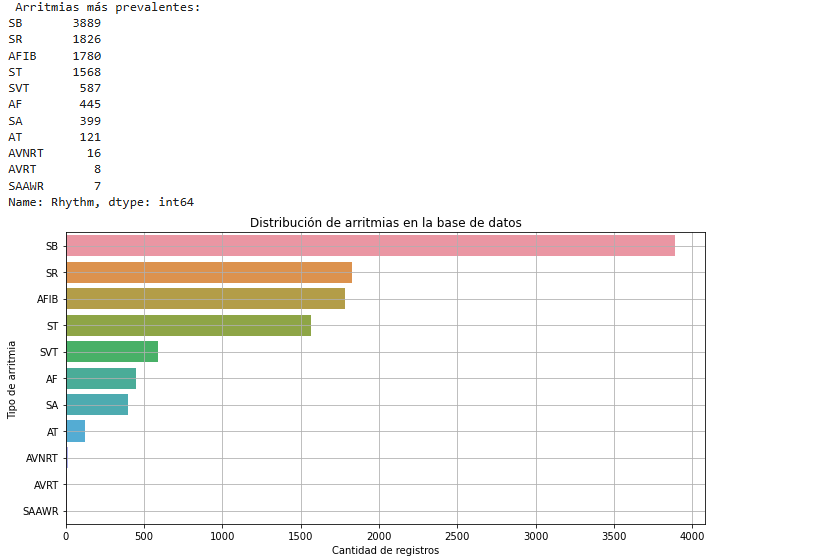

fMP a las señales filtradas, para compara con lo obtenido hasta el momento 

In [ ]:
import os
from glob import glob
import numpy as np
import pandas as pd
from scipy.signal import welch

# 1. Función para cargar derivación II desde archivos ya filtrados
def cargar_derivacion_II_denoised(ruta_archivo):
    data = np.genfromtxt(ruta_archivo, delimiter=',', skip_header=1)
    return data[:, 1]  # segunda columna = derivación II

# 2. Función para obtener fMP con Welch
def obtener_fmp(signal, fs=500):
    f, Pxx = welch(signal, fs=fs, nperseg=1024)
    return f[np.argmax(Pxx)]

# 3. Recorrer archivos .csv en ECGDataDenoised/
ruta_denoised = "ECGDataDenoised"
archivos_denoised = glob(os.path.join(ruta_denoised, "*.csv"))
print(f" Archivos encontrados en ECGDataDenoised: {len(archivos_denoised)}")

resultados_denoised = []

for ruta in archivos_denoised:
    try:
        nombre = os.path.basename(ruta)
        registro = os.path.splitext(nombre)[0]
        senal = cargar_derivacion_II_denoised(ruta)
        
        if len(senal) == 0:
            print(f" Señal vacía: {registro}")
            continue
        
        fmp = obtener_fmp(senal)
        resultados_denoised.append({"Registro": registro, "FMP_denoised": fmp})
    
    except Exception as e:
        print(f" Error procesando {ruta}: {type(e).__name__} → {e}")

# 4. Crear DataFrame con los resultados
df_denoised = pd.DataFrame(resultados_denoised)

# 5. Cargar archivo Diagnostics.xlsx para asignar arritmia
df_diag = pd.read_excel("Diagnostics.xlsx")
df_diag.columns = df_diag.columns.str.strip()
df_diag = df_diag.rename(columns={"FileName": "Registro", "Rhythm": "Estado"})

# 6. Unir fMP_denoised con arritmias
df_denoised = df_denoised.merge(df_diag[["Registro", "Estado"]], on="Registro", how="left")

# 7. Guardar resultado
df_denoised.to_excel("Resultados_FMP_Denoised_con_arritmia.xlsx", index=False)
print(" Archivo Resultados_FMP_Denoised_con_arritmia.xlsx creado correctamente.")

 Archivos encontrados en ECGDataDenoised: 10646
 Error procesando ECGDataDenoised\MUSE_20180113_124215_52000.csv: ValueError → Some errors were detected !
    Line #1926 (got 5 columns instead of 12)
 Archivo Resultados_FMP_Denoised_con_arritmia.xlsx creado correctamente.


Verificacion del archivo creado

In [ ]:
# Cargar archivo generado
df_denoised = pd.read_excel("Resultados_FMP_Denoised_con_arritmia.xlsx")
df_denoised.columns = df_denoised.columns.str.strip()

# Ver columnas presentes
print(" Columnas del archivo:")
print(df_denoised.columns.tolist())

# Total de registros
print(f"\n Total de registros: {len(df_denoised)}")

# Primeras 5 filas
print("\n Primeros 5 registros:")
print(df_denoised.head())

# Conteo por tipo de arritmia
print("\n Conteo por tipo de arritmia:")
print(df_denoised["Estado"].value_counts(dropna=False))

# Verificación de valores faltantes
print("\n Valores faltantes por columna:")
print(df_denoised.isnull().sum())

 Columnas del archivo:
['Registro', 'FMP_denoised', 'Estado']

 Total de registros: 10645

 Primeros 5 registros:
                     Registro  FMP_denoised Estado
0  MUSE_20180111_155115_19000      1.953125     ST
1  MUSE_20180111_155154_74000      4.882812   AFIB
2  MUSE_20180111_155203_15000      3.906250   AFIB
3  MUSE_20180111_155249_70000      1.953125     ST
4  MUSE_20180111_155542_84000      3.417969     AF

 Conteo por tipo de arritmia:
SB       3888
SR       1826
AFIB     1780
ST       1568
SVT       587
AF        445
SA        399
AT        121
AVNRT      16
AVRT        8
SAAWR       7
Name: Estado, dtype: int64

 Valores faltantes por columna:
Registro        0
FMP_denoised    0
Estado          0
dtype: int64


Analisis comparativo

Tipos de arritmia encontrados: ['ST' 'AFIB' 'AF' 'SVT' 'SA' 'SB' 'SR' 'AT' 'AVNRT' 'SAAWR' 'AVRT']

 Análisis para arritmia: ST
Media fMP Data = 4.86 Hz
Media fMP Denoised = 5.53 Hz
Wilcoxon: W = 2657.500, p = 5.608e-37


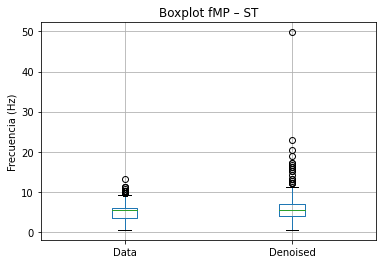


 Análisis para arritmia: AFIB
Media fMP Data = 3.14 Hz
Media fMP Denoised = 3.93 Hz
Wilcoxon: W = 14700.000, p = 1.153e-60


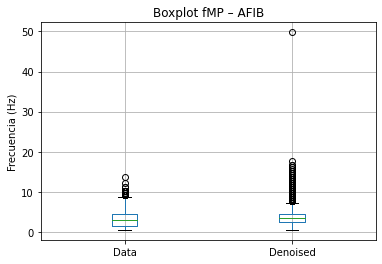


 Análisis para arritmia: AF
Media fMP Data = 3.81 Hz
Media fMP Denoised = 4.22 Hz
Wilcoxon: W = 531.000, p = 1.363e-06


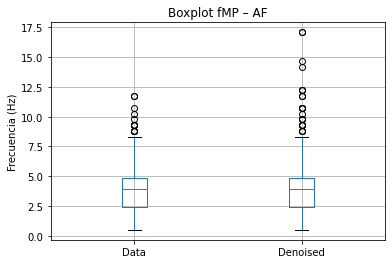


 Análisis para arritmia: SVT
Media fMP Data = 4.49 Hz
Media fMP Denoised = 4.61 Hz
Wilcoxon: W = 2372.500, p = 9.885e-01


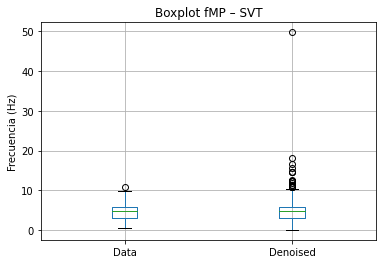


 Análisis para arritmia: SA
Media fMP Data = 3.06 Hz
Media fMP Denoised = 3.94 Hz
Wilcoxon: W = 754.000, p = 2.121e-16


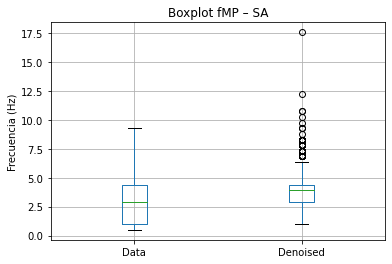


 Análisis para arritmia: SB
Media fMP Data = 2.05 Hz
Media fMP Denoised = 3.17 Hz
Wilcoxon: W = 103048.000, p = 2.038e-216


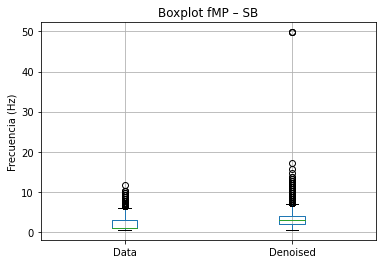


 Análisis para arritmia: SR
Media fMP Data = 3.69 Hz
Media fMP Denoised = 4.38 Hz
Wilcoxon: W = 13785.500, p = 1.121e-53


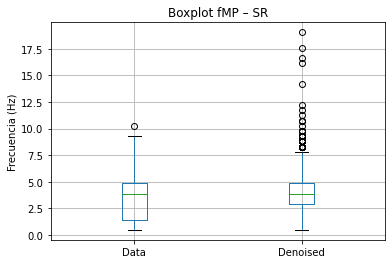


 Análisis para arritmia: AT
Media fMP Data = 3.90 Hz
Media fMP Denoised = 4.60 Hz
Wilcoxon: W = 37.000, p = 1.232e-03


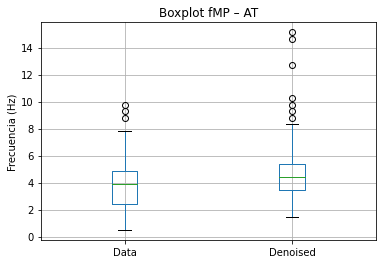


 Análisis para arritmia: AVNRT
Media fMP Data = 5.34 Hz
Media fMP Denoised = 4.97 Hz
Wilcoxon: W = 0.000, p = 1.573e-01


c:\Users\DELL\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\DELL\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


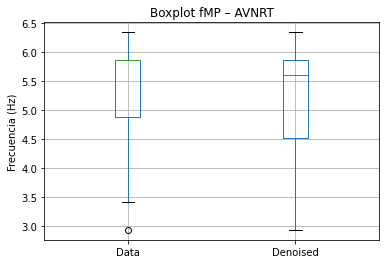


 Análisis para arritmia: SAAWR
Media fMP Data = 2.51 Hz
Media fMP Denoised = 3.21 Hz
Wilcoxon: W = 4.000, p = 3.363e-01


c:\Users\DELL\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\DELL\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


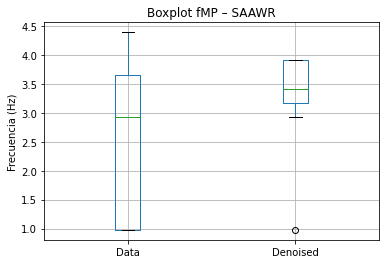


 Análisis para arritmia: AVRT
Media fMP Data = 4.82 Hz
Media fMP Denoised = 4.82 Hz
No se pudo aplicar Wilcoxon: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.


c:\Users\DELL\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


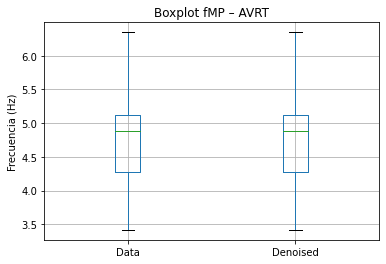

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, wilcoxon

# 1. Cargar los archivos
df_data = pd.read_excel("Resultados_FMP_Proyecto3_con_arritmia.xlsx")
df_denoised = pd.read_excel("Resultados_FMP_Denoised_con_arritmia.xlsx")

# 2. Limpiar columnas
df_data.columns = df_data.columns.str.strip()
df_denoised.columns = df_denoised.columns.str.strip()

# 3. Merge por Registro
df_cmp = df_data.merge(df_denoised[["Registro", "FMP_denoised"]], on="Registro", how="inner")

# 4. Verificar cuántos tipos de arritmia hay
tipos_arritmia = df_cmp["Estado"].unique()
print("Tipos de arritmia encontrados:", tipos_arritmia)

# 5. Análisis por tipo de arritmia
for arritmia in tipos_arritmia:
    grupo = df_cmp[df_cmp["Estado"] == arritmia]

    if len(grupo) < 5:
        print(f"\n {arritmia} tiene solo {len(grupo)} registros. Se omite análisis por baja muestra.")
        continue

    print(f"\n Análisis para arritmia: {arritmia}")
    
    mean_fmp = grupo["FMP"].mean()
    mean_denoised = grupo["FMP_denoised"].mean()
    
    print(f"Media fMP Data = {mean_fmp:.2f} Hz")
    print(f"Media fMP Denoised = {mean_denoised:.2f} Hz")
    
    # Prueba pareada (Wilcoxon si no normal, t-test si deseas)
    try:
        stat, p = wilcoxon(grupo["FMP"], grupo["FMP_denoised"])
        print(f"Wilcoxon: W = {stat:.3f}, p = {p:.3e}")
    except Exception as e:
        print(f"No se pudo aplicar Wilcoxon: {e}")
    
    # Boxplot para este tipo de arritmia
    plt.figure()
    grupo[["FMP", "FMP_denoised"]].boxplot()
    plt.title(f"Boxplot fMP – {arritmia}")
    plt.ylabel("Frecuencia (Hz)")
    plt.xticks([1, 2], ["Data", "Denoised"])
    plt.grid(True)
    plt.show()

Hay empates en las arritmias AVRT, SAAWR, AVNRT. Esto afecta la prueba Wilcoxon pues el Wilcoxon Signed-Rank Test requiere que no haya empates en las diferencias entre las muestras y cuando hay empates, la prueba cambia automáticamente al cálculo de un valor p aproximado usando una distribución normal.

Vamos entonces a revisar si la cantidad de empates es alta, si hay muchos empates, Wilcoxon no es ideal(usar el test de signos de McNemar o el test de rangos con la corrección de continuidad) y si los empates son pocos, el p-valor aproximado puede ser aceptable.



In [82]:
import warnings
# Filtrar grupo
grupo = df_cmp[df_cmp["Estado"] == arritmia]

# Calcular las diferencias
diferencias = grupo["FMP"] - grupo["FMP_denoised"]
n_empates = len(diferencias[diferencias == 0])

print(f"\n Número de empates: {n_empates} en {len(grupo)} registros")

# Si hay empates, advierte que se está utilizando aproximación normal
if n_empates > 0:
    print(" Hay empates en las diferencias, usando aproximación normal para el p-valor.")

# 2. Intentar aplicar Wilcoxon
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    try:
        stat, p = wilcoxon(grupo["FMP"], grupo["FMP_denoised"])
        print(f"Wilcoxon: W = {stat:.3f}, p = {p:.3e}")
    except Exception as e:
        print(f"No se pudo aplicar Wilcoxon: {e}")


 Número de empates: 8 en 8 registros
 Hay empates en las diferencias, usando aproximación normal para el p-valor.
No se pudo aplicar Wilcoxon: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.


esto indica que todas las diferencias entre fMP y fMP_denoised son cero para los registros de esas arritmias. Es decir, no hay diferencia alguna entre los dos métodos para esos registros específicos (todos los fMP son iguales en ambos métodos). Cuando todos los fMP son iguales, no hay variabilidad entre las señales y la prueba de Wilcoxon no puede ser aplicada porque no hay diferencia en las "rango de datos" (todas las diferencias son cero). Esto es precisamente lo que ocurrió en las arritmias como AVRT, SAAWR y AVNRT, donde probablemente nuestro filtrado ha producido resultados muy similares al filtrado profesional.

Veamos si todos los datos de esas arritmias son cero

In [87]:

# 1. Obtener las arritmias únicas
tipos_arritmia = df_cmp["Estado"].unique()

# 2. Recorrer todas las arritmias
for arritmia in tipos_arritmia:
    # Filtrar grupo para la arritmia específica
    grupo = df_cmp[df_cmp["Estado"] == arritmia]
    
    # Calcular las diferencias entre fMP y fMP_denoised
    diferencias = grupo["FMP"] - grupo["FMP_denoised"]
    
    # Ver todas las diferencias
    print(f"\nDiferencias para {arritmia}:")
    print(diferencias)

    # Verificar si todas las diferencias son cero
    if all(diferencias == 0):
        print(f"Todas las diferencias son cero para la arritmia {arritmia}. No se necesita prueba de Wilcoxon.")
    else:
        print(f"Algunas diferencias son diferentes de cero en {arritmia}. se puede con prueba de Wilcoxon.")
        
        # Si no son todas cero, intentar aplicar Wilcoxon
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            try:
                stat, p = wilcoxon(grupo["FMP"], grupo["FMP_denoised"])
                print(f"Wilcoxon: W = {stat:.3f}, p = {p:.3e}")
            except Exception as e:
                print(f"No se pudo aplicar Wilcoxon: {e}")


Diferencias para ST:
0       0.000000
3       0.000000
5      -5.371094
16      0.000000
17     -3.417969
          ...   
8068    0.000000
8069    0.000000
8071    0.000000
8080    0.000000
8083    0.000000
Length: 1568, dtype: float64
Algunas diferencias son diferentes de cero en ST. se puede con prueba de Wilcoxon.
Wilcoxon: W = 2657.500, p = 5.608e-37

Diferencias para AFIB:
1         0.000000
2         0.000000
12        0.000000
14        0.000000
18        0.000000
           ...    
10600   -13.183594
10601     0.000000
10602    -3.417969
10603     0.000000
10604    -1.464844
Length: 1780, dtype: float64
Algunas diferencias son diferentes de cero en AFIB. se puede con prueba de Wilcoxon.
Wilcoxon: W = 14700.000, p = 1.153e-60

Diferencias para AF:
4        0.000000
81       0.000000
238      0.000000
282      0.000000
334      0.000000
           ...   
10467   -3.417969
10468    0.000000
10469    0.000000
10470    0.000000
10471    0.000000
Length: 445, dtype: float64
Algunas

por ejemplo no hay diferencia entre los fMP calculados por tu filtrado y los fMP calculados en las señales filtradas por profesionales para la arritmia AVRT.

Esto significa que nuestro método produjo resultados idénticos a los de los profesionales para estas señales, y la prueba de Wilcoxon no es necesaria.

Ahora comparemos con U de Mann–Whitney entre las señales filtradas por nosotros vs por profesionales

H₀: Las distribuciones de fMP para AFIB y SB son idénticas. Es decir, no hay diferencias entre las dos distribuciones de fMP.

H₁: Las distribuciones de fMP para AFIB y SB son diferentes. Esto implica que la distribución de fMP de uno de los grupos es más alta o más baja que la del otro grupo.

In [92]:
from scipy.stats import mannwhitneyu

# 1. Cargar los archivos (tu flujo y señales denoised por profesionales)
df_tuyo = pd.read_excel("Resultados_FMP_Proyecto3_con_arritmia.xlsx")
df_denoised = pd.read_excel("Resultados_FMP_Denoised_con_arritmia.xlsx")

# Limpiar nombres de columnas
df_tuyo.columns = df_tuyo.columns.str.strip()
df_denoised.columns = df_denoised.columns.str.strip()

# 2. Filtrar los grupos AFIB y SB en tus señales (fMP procesado por ti)
grupo_afib_tuyo = df_tuyo[df_tuyo["Estado"] == "AFIB"]["FMP"]
grupo_sb_tuyo = df_tuyo[df_tuyo["Estado"] == "SB"]["FMP"]

# 3. Filtrar los grupos AFIB y SB en las señales denoised (fMP filtrado profesionalmente)
grupo_afib_denoised = df_denoised[df_denoised["Estado"] == "AFIB"]["FMP_denoised"]
grupo_sb_denoised = df_denoised[df_denoised["Estado"] == "SB"]["FMP_denoised"]

# Verificar tamaños de los grupos
print(f"Tamaño grupo AFIB (tuyo): {len(grupo_afib_tuyo)}")
print(f"Tamaño grupo SB (tuyo): {len(grupo_sb_tuyo)}")
print(f"Tamaño grupo AFIB (denoised): {len(grupo_afib_denoised)}")
print(f"Tamaño grupo SB (denoised): {len(grupo_sb_denoised)}")

# 4. Aplicar Mann-Whitney U en los fMP de tus señales (AFIB vs SB)
stat_tuyo, p_tuyo = mannwhitneyu(grupo_afib_tuyo, grupo_sb_tuyo, alternative="two-sided")
print("\n Mann–Whitney U Test (AFIB vs SB - Nuestro filtro):")
print(f"diferencia entre las distribuciones = {stat_tuyo:.3f}, p-value = {p_tuyo:.3e}")

if p_tuyo < 0.05:
    print(" Diferencia significativa entre AFIB y SB en tus señales filtradas.")
else:
    print(" No hay diferencia significativa entre AFIB y SB en tus señales filtradas.")

# 5. Aplicar Mann-Whitney U en los fMP de las señales denoised (AFIB vs SB)
stat_denoised, p_denoised = mannwhitneyu(grupo_afib_denoised, grupo_sb_denoised, alternative="two-sided")
print("\n Mann–Whitney U Test (AFIB vs SB - Filtrado profesional):")
print(f"diferencia entre las distribuciones = {stat_denoised:.3f}, p-value = {p_denoised:.3e}")

if p_denoised < 0.05:
    print(" Diferencia significativa entre AFIB y SB en las señales denoised.")
else:
    print(" No hay diferencia significativa entre AFIB y SB en las señales denoised.")

Tamaño grupo AFIB (tuyo): 1780
Tamaño grupo SB (tuyo): 3889
Tamaño grupo AFIB (denoised): 1780
Tamaño grupo SB (denoised): 3888

 Mann–Whitney U Test (AFIB vs SB - Nuestro filtro):
diferencia entre las distribuciones = 4826811.500, p-value = 1.035e-134
 Diferencia significativa entre AFIB y SB en tus señales filtradas.

 Mann–Whitney U Test (AFIB vs SB - Filtrado profesional):
diferencia entre las distribuciones = 4180119.000, p-value = 6.614e-37
 Diferencia significativa entre AFIB y SB en las señales denoised.


la diferencia entre las distribuciones de los dos grupos que estamos comparando (en este caso AFIB vs SB). Es una medida de la cantidad de desajuste entre las dos distribuciones. 

1. Mann–Whitney U Test (AFIB vs SB - Nuestro filtro)
Statistic = 4,826,811.500

p-value = 1.035e-134

El estadístico U de 4,826,811.500 es bastante alto, lo que indica que hay una gran diferencia en las distribuciones de fMP entre AFIB y SB en las señales que procesaste.

El p-valor es extremadamente bajo (p < 0.05), lo que rechaza la hipótesis nula y concluye que hay una diferencia estadísticamente significativa entre AFIB y SB en tus señales filtradas

2. Mann–Whitney U Test (AFIB vs SB - Filtrado profesional)
Statistic = 4,180,119.000

p-value = 6.614e-37

El estadístico U para las señales filtradas profesionalmente es también alto, lo que indica una gran diferencia entre los dos grupos.

El p-valor sigue siendo extremadamente bajo (p < 0.05), lo que también indica una diferencia significativa entre AFIB y SB en las señales filtradas por profesionales.

Hay una diferencia estadísticamente significativa entre las distribuciones de fMP de AFIB y SB, lo que significa que los valores de fMP no son iguales entre las dos arritmias. Esto implica que los dos grupos tienen características diferentes en términos de la frecuencia de máxima potencia (fMP).

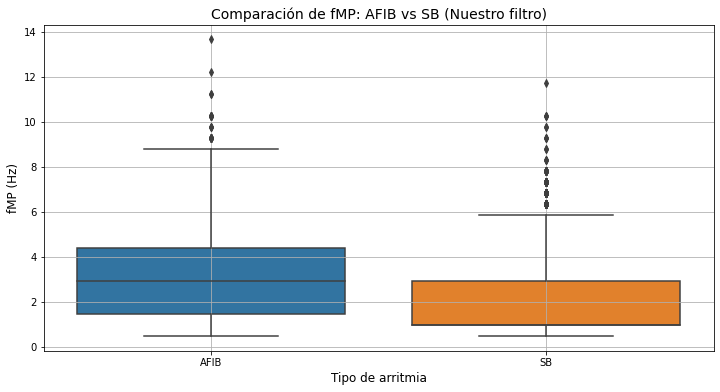

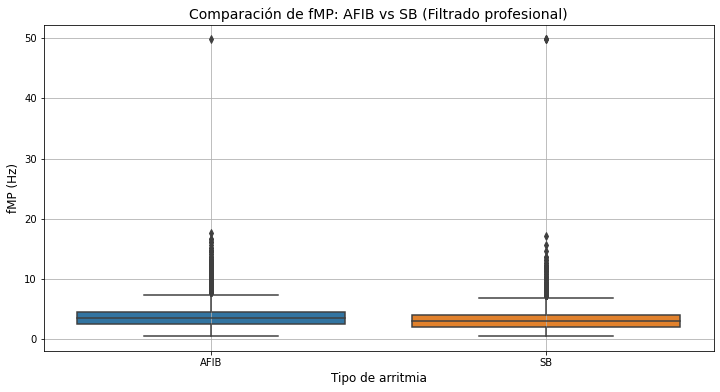

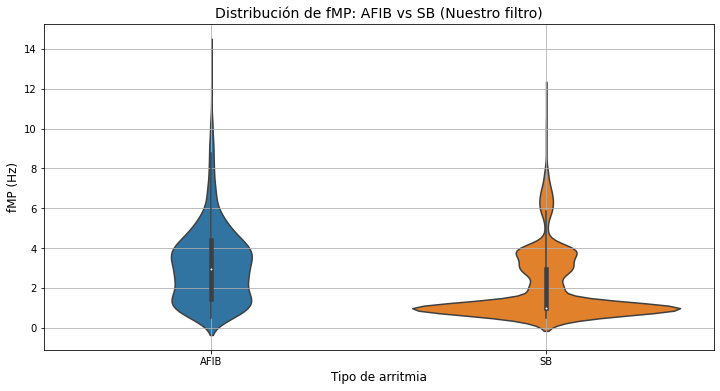

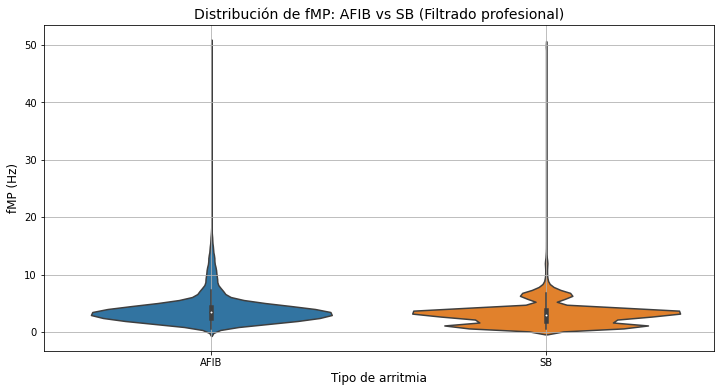

In [95]:
import seaborn as sns

# Filtrar los grupos de AFIB y SB para tus señales (fMP procesado por ti)
grupo_afib_tuyo = df_tuyo[df_tuyo["Estado"] == "AFIB"]["FMP"]
grupo_sb_tuyo = df_tuyo[df_tuyo["Estado"] == "SB"]["FMP"]

# Filtrar los grupos de AFIB y SB para las señales denoised (fMP filtrado profesionalmente)
grupo_afib_denoised = df_denoised[df_denoised["Estado"] == "AFIB"]["FMP_denoised"]
grupo_sb_denoised = df_denoised[df_denoised["Estado"] == "SB"]["FMP_denoised"]

# Gráfico de boxplot para AFIB vs SB en tus señales (fMP procesado por ti)
plt.figure(figsize=(12, 6))
sns.boxplot(x="Estado", y="FMP", data=df_tuyo[df_tuyo["Estado"].isin(["AFIB", "SB"])])
plt.title("Comparación de fMP: AFIB vs SB (Nuestro filtro)", fontsize=14)
plt.xlabel("Tipo de arritmia", fontsize=12)
plt.ylabel("fMP (Hz)", fontsize=12)
plt.grid(True)
plt.show()

# Gráfico de boxplot para AFIB vs SB en las señales denoised (fMP filtrado profesionalmente)
plt.figure(figsize=(12, 6))
sns.boxplot(x="Estado", y="FMP_denoised", data=df_denoised[df_denoised["Estado"].isin(["AFIB", "SB"])])
plt.title("Comparación de fMP: AFIB vs SB (Filtrado profesional)", fontsize=14)
plt.xlabel("Tipo de arritmia", fontsize=12)
plt.ylabel("fMP (Hz)", fontsize=12)
plt.grid(True)
plt.show()

# Gráfico de violin plot para ver la distribución de las dos arritmias en tus señales (fMP procesado por ti)
plt.figure(figsize=(12, 6))
sns.violinplot(x="Estado", y="FMP", data=df_tuyo[df_tuyo["Estado"].isin(["AFIB", "SB"])])
plt.title("Distribución de fMP: AFIB vs SB (Nuestro filtro)", fontsize=14)
plt.xlabel("Tipo de arritmia", fontsize=12)
plt.ylabel("fMP (Hz)", fontsize=12)
plt.grid(True)
plt.show()

# Gráfico de violin plot para ver la distribución de las dos arritmias en las señales denoised (fMP filtrado profesionalmente)
plt.figure(figsize=(12, 6))
sns.violinplot(x="Estado", y="FMP_denoised", data=df_denoised[df_denoised["Estado"].isin(["AFIB", "SB"])])
plt.title("Distribución de fMP: AFIB vs SB (Filtrado profesional)", fontsize=14)
plt.xlabel("Tipo de arritmia", fontsize=12)
plt.ylabel("fMP (Hz)", fontsize=12)
plt.grid(True)
plt.show()

<Figure size 1440x720 with 0 Axes>

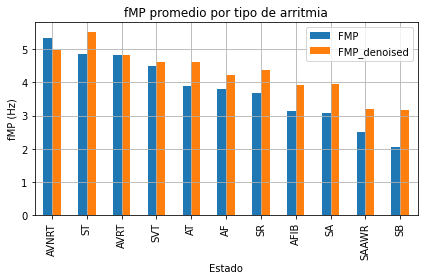

In [97]:
#  Barras por tipo de arritmia
plt.figure(figsize=(20,10))
mean_fmp = df_cmp.groupby("Estado")[["FMP", "FMP_denoised"]].mean().sort_values("FMP", ascending=False)
mean_fmp.plot(kind="bar")
plt.title("fMP promedio por tipo de arritmia")
plt.ylabel("fMP (Hz)")
plt.grid(True)
plt.tight_layout()
plt.show()




Barras agrupadas por tipo de arritmia: fMP promedio de cada método, agrupado por el tipo de ritmo/arritmia (Estado). Nos da idea de como cambia la fMP dependiendo de la arritmia y permite ver si tu método capta diferencias más claras o más suaves entre tipos de ritmo.


Analisis de concordancia señal por señal


Analizando la arritmia: ST
 Pearson correlation: r = 0.586, p = 4.564e-145


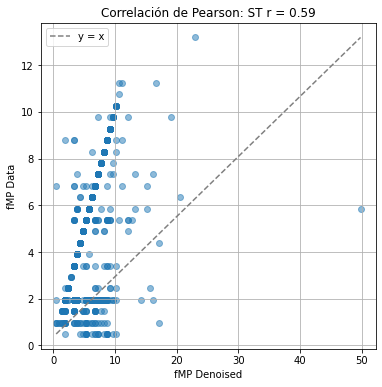

C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Media"] = (grupo["FMP"] + grupo["FMP_denoised"]) / 2
C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Diferencia"] = grupo["FMP"] - grupo["FMP_denoised"]


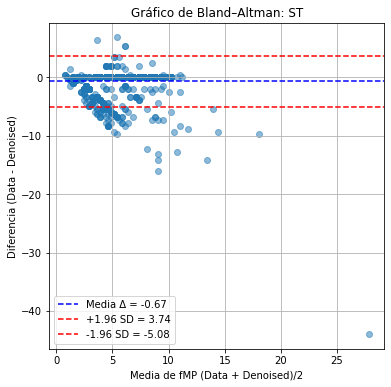


Analizando la arritmia: AFIB
 Pearson correlation: r = 0.481, p = 1.037e-103


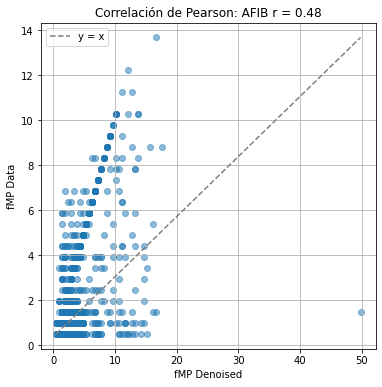

C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Media"] = (grupo["FMP"] + grupo["FMP_denoised"]) / 2
C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Diferencia"] = grupo["FMP"] - grupo["FMP_denoised"]


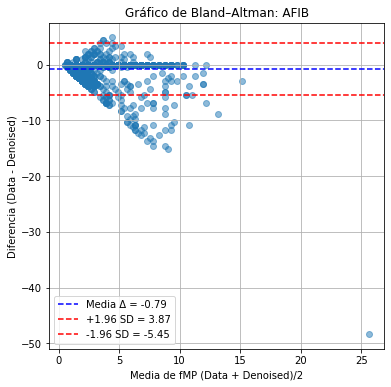


Analizando la arritmia: AF
 Pearson correlation: r = 0.623, p = 3.270e-49


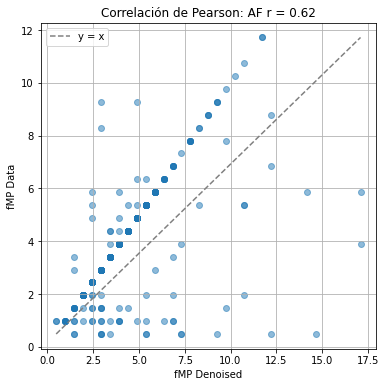

C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Media"] = (grupo["FMP"] + grupo["FMP_denoised"]) / 2
C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Diferencia"] = grupo["FMP"] - grupo["FMP_denoised"]


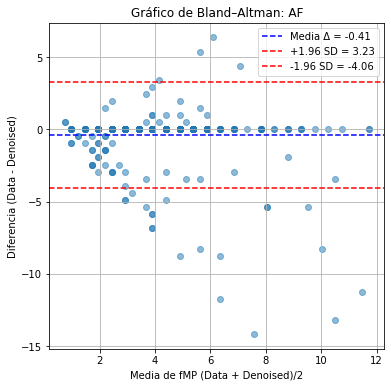


Analizando la arritmia: SVT
 Pearson correlation: r = 0.476, p = 1.657e-34


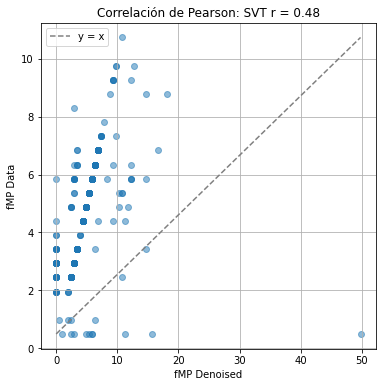

C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Media"] = (grupo["FMP"] + grupo["FMP_denoised"]) / 2
C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Diferencia"] = grupo["FMP"] - grupo["FMP_denoised"]


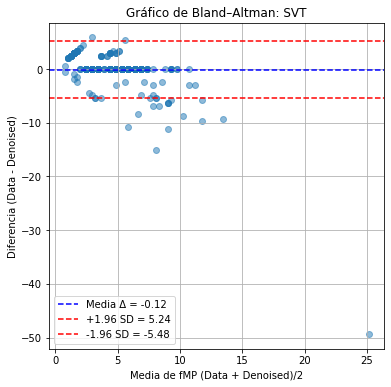


Analizando la arritmia: SA
 Pearson correlation: r = 0.539, p = 1.647e-31


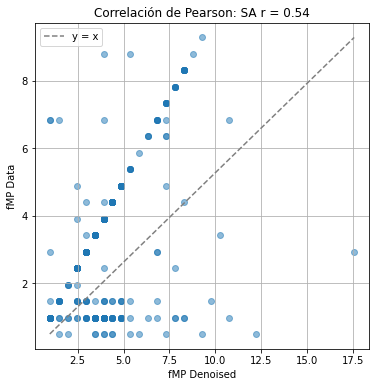

C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Media"] = (grupo["FMP"] + grupo["FMP_denoised"]) / 2
C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Diferencia"] = grupo["FMP"] - grupo["FMP_denoised"]


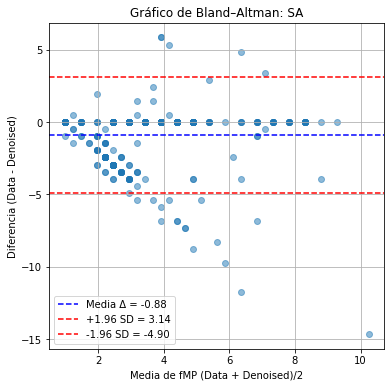


Analizando la arritmia: SB
 Pearson correlation: r = 0.357, p = 2.157e-117


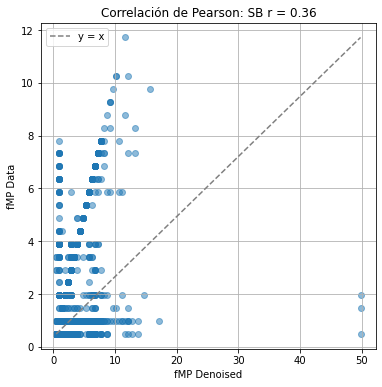

C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Media"] = (grupo["FMP"] + grupo["FMP_denoised"]) / 2
C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Diferencia"] = grupo["FMP"] - grupo["FMP_denoised"]


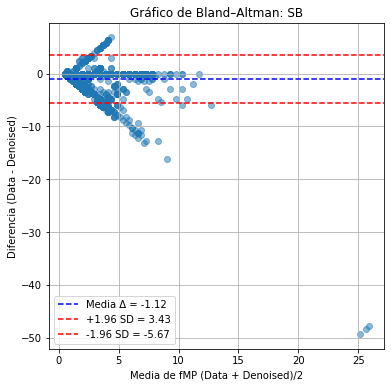


Analizando la arritmia: SR
 Pearson correlation: r = 0.600, p = 4.596e-179


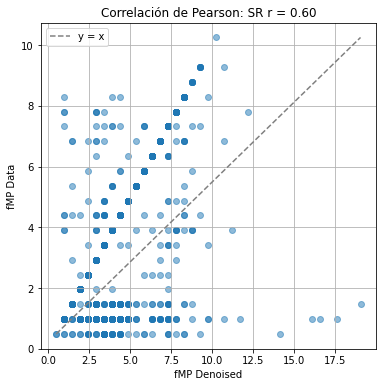

C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Media"] = (grupo["FMP"] + grupo["FMP_denoised"]) / 2
C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Diferencia"] = grupo["FMP"] - grupo["FMP_denoised"]


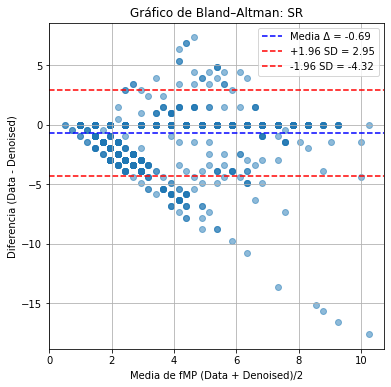


Analizando la arritmia: AT
 Pearson correlation: r = 0.313, p = 4.690e-04


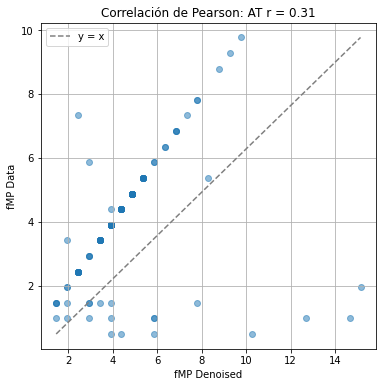

C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Media"] = (grupo["FMP"] + grupo["FMP_denoised"]) / 2
C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Diferencia"] = grupo["FMP"] - grupo["FMP_denoised"]


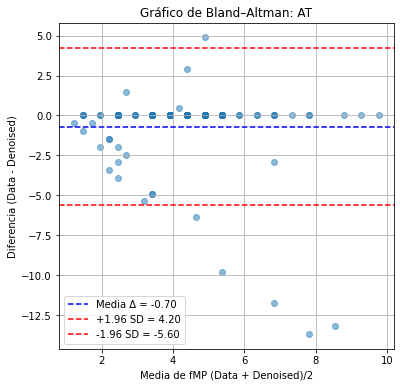


Analizando la arritmia: AVNRT
 Pearson correlation: r = 0.603, p = 1.349e-02


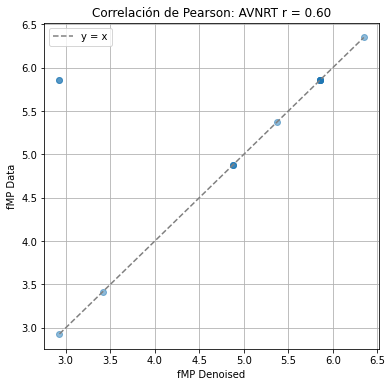

C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Media"] = (grupo["FMP"] + grupo["FMP_denoised"]) / 2
C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Diferencia"] = grupo["FMP"] - grupo["FMP_denoised"]


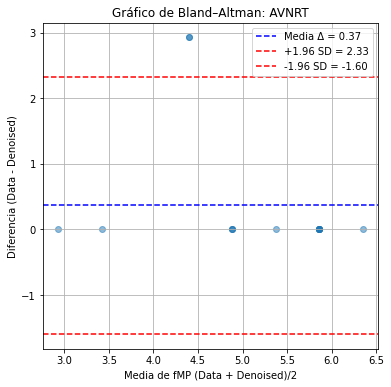


Analizando la arritmia: SAAWR
 Pearson correlation: r = -0.166, p = 7.228e-01


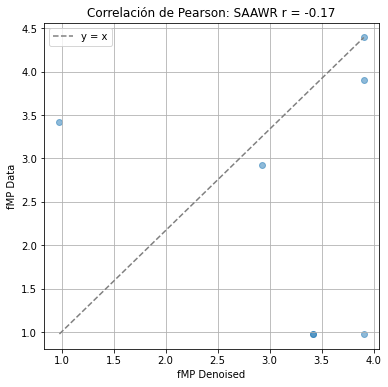

C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Media"] = (grupo["FMP"] + grupo["FMP_denoised"]) / 2
C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Diferencia"] = grupo["FMP"] - grupo["FMP_denoised"]


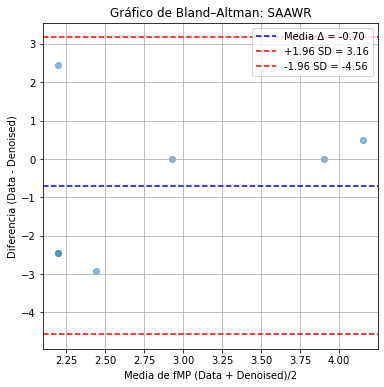


Analizando la arritmia: AVRT
 Pearson correlation: r = 1.000, p = 0.000e+00


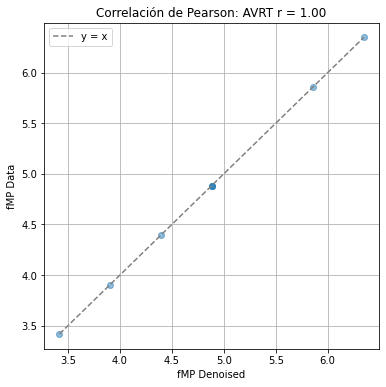

C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Media"] = (grupo["FMP"] + grupo["FMP_denoised"]) / 2
C:\Users\DELL\AppData\Local\Temp\ipykernel_7964\3729513244.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo["Diferencia"] = grupo["FMP"] - grupo["FMP_denoised"]


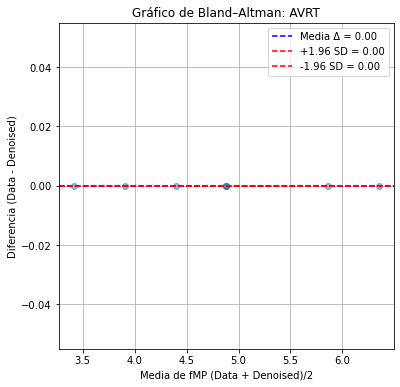

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 1. Cargar ambos archivos y fusionarlos
df_data = pd.read_excel("Resultados_FMP_Proyecto3_con_arritmia.xlsx")
df_denoised = pd.read_excel("Resultados_FMP_Denoised_con_arritmia.xlsx")

df_data.columns = df_data.columns.str.strip()
df_denoised.columns = df_denoised.columns.str.strip()

df_cmp = df_data.merge(df_denoised[["Registro", "FMP_denoised"]], on="Registro", how="inner")

# Obtener las arritmias únicas
tipos_arritmia = df_cmp["Estado"].unique()

# 2. Recorrer todas las arritmias para hacer el análisis de Pearson y Bland-Altman
for arritmia in tipos_arritmia:
    print(f"\nAnalizando la arritmia: {arritmia}")

    # Filtrar los datos para esta arritmia
    grupo = df_cmp[df_cmp["Estado"] == arritmia]
    
    # 3. Correlación de Pearson
    r, p = pearsonr(grupo["FMP"], grupo["FMP_denoised"])
    print(f" Pearson correlation: r = {r:.3f}, p = {p:.3e}")
    
    # Gráfico de dispersión con línea de identidad
    plt.figure(figsize=(6, 6))
    plt.scatter(grupo["FMP_denoised"], grupo["FMP"], alpha=0.5)
    plt.plot([grupo["FMP_denoised"].min(), grupo["FMP_denoised"].max()],
             [grupo["FMP"].min(), grupo["FMP"].max()],
             color='gray', linestyle='--', label='y = x')
    plt.xlabel("fMP Denoised")
    plt.ylabel("fMP Data")
    plt.title(f"Correlación de Pearson: {arritmia} r = {r:.2f}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Bland–Altman plot
    grupo["Media"] = (grupo["FMP"] + grupo["FMP_denoised"]) / 2
    grupo["Diferencia"] = grupo["FMP"] - grupo["FMP_denoised"]
    mean_diff = grupo["Diferencia"].mean()
    std_diff = grupo["Diferencia"].std()

    # Límites de concordancia
    lim_sup = mean_diff + 1.96 * std_diff
    lim_inf = mean_diff - 1.96 * std_diff

    # Gráfico de Bland–Altman
    plt.figure(figsize=(6, 6))
    plt.scatter(grupo["Media"], grupo["Diferencia"], alpha=0.5)
    plt.axhline(mean_diff, color='blue', linestyle='--', label=f"Media Δ = {mean_diff:.2f}")
    plt.axhline(lim_sup, color='red', linestyle='--', label=f"+1.96 SD = {lim_sup:.2f}")
    plt.axhline(lim_inf, color='red', linestyle='--', label=f"-1.96 SD = {lim_inf:.2f}")
    plt.xlabel("Media de fMP (Data + Denoised)/2")
    plt.ylabel("Diferencia (Data - Denoised)")
    plt.title(f"Gráfico de Bland–Altman: {arritmia}")
    plt.legend()
    plt.grid(True)
    plt.show()

Para cada arritmia, da el coeficiente de correlación de Pearson y el gráfico de dispersión que muestra cómo se alinean las distribuciones de fMP de nuestras señales y las de los profesionales.

El Bland-Altman plot da una visualización detallada de las diferencias entre ambos métodos, mostrando los límites de concordancia y la media de las diferencias.